# Data preparation:

Creates:
- monthly RCMs concatenated with all variables
- GCM like monthly RCM with all variables
- GCM with same variables as in RCM and same time-frame

## Setting up:

In [1]:
# run script that installs missing libraries
! chmod 755 ../../scripts.sh
! ../../scripts.sh

  Using cached cf_units-3.0.1.post0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (491 kB)
  Using cached antlr4_python3_runtime-4.7.2-py3-none-any.whl
  Using cached plotly-5.6.0-py2.py3-none-any.whl (27.7 MB)
  Using cached tenacity-8.0.1-py3-none-any.whl (24 kB)
  Using cached python_dateutil-2.8.2-py2.py3-none-any.whl (247 kB)
  Attempting uninstall: python-dateutil
    Found existing installation: python-dateutil 2.7.5
    Uninstalling python-dateutil-2.7.5:
      Successfully uninstalled python-dateutil-2.7.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sat-stac 0.4.1 requires python-dateutil~=2.7.5, but you have python-dateutil 2.8.2 which is incompatible.
intake-esm 2021.8.17 requires h5netcdf>=0.8.1, but you have h5netcdf 0.0.0 which is incompatible.
earthdata 0.2.2 requires python-benedict<0.26,>=0.25, but you have python-benedict 0.24.3

In [2]:
import os
import sys

from matplotlib import pyplot as plt
import matplotlib.path as mpath
import numpy as np
import pandas as pd
import xarray as xr
import cartopy
import cf_units
from datetime import datetime
from datetime import timedelta
import rasterio
import cartopy.crs as ccrs
import gcsfs
from tqdm import tqdm
import pyproj
from pyproj import Transformer
from google.cloud import storage
from re import search
from os import listdir
from os.path import isfile, join
from scipy import ndimage

# import self made python files

sys.path.append('../')
from process_pangeo import *
from GC_scripts import *
from processRCM import *
from reprojectionFunctions import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
# Google cloud
PROJECT = 'ee-iceshelf-gee4geo'
BUCKET = "ee-downscalingclimatemodels"

os.environ["GCLOUD_PROJECT"] = PROJECT
storage_client = storage.Client()
bucket = storage_client.bucket(BUCKET)

In [4]:
def plotAllVar(GCM_xy, m=3, n=3, name='GCM'):
    vars_ = list(GCM_xy.data_vars)
    coords = list(GCM_xy.coords)
    f = plt.figure(figsize=(20, 10))
    map_proj = ccrs.SouthPolarStereo(central_longitude=0.0, globe=None)
    for i in range(len(vars_)):
        var = vars_[i]
        ax = plt.subplot(m, n, i + 1, projection=ccrs.SouthPolarStereo())
        GCM_xy[var].isel(time=0).plot(ax=ax, x='x', y='y',
                transform=ccrs.SouthPolarStereo(), add_colorbar=True)
        ax.coastlines('10m', color='black')
        ax.gridlines(draw_labels=False)
        ax.set_title(f'{GCM_xy[var].long_name} ({var})')
    plt.suptitle(f'First time step {GCM_xy.time[0].values} of {name}')

## Read data:

### Monthly GCM xy: 
GCM projected from lat/lon to polar stereographic coordinates. 

#### Vars GCM:

For precipitation conversion: 1 kg/m2/s = 86400 mm/day.
Pressure level: near surface --> 925 Hpa

#### From pangeo:
- **pr**: precipitation [kg m-2 s-1] --> need to change to  [mmWE/day], eq: **RF+SF?**
- **psl**: sea level pressure [Pa] --> need to change to [hPa], eq: **SP**
- **rlut**: outgoing longwave radiation [W/m2], eq: **LWD**
- **rsut**: outgoing shortwave radiation [W/m2], eq: **SWD**
- **rsdt**: incident shortwave radiation [W/m2]
- **tas**: near surface air temp [K] --> need to change to [°C], eq: **TT**
- **uas**: eastward near surface wind [m/s], eq: **UUP** at surface pressure (PLEV:7)
- **vas**: northward near surface wind [m/s], eq: **VVP** at surface pressure (PLEV:7)

#### From australian website:
- **huss**: near surface specific humidity [1] --> what is this unit? eq: **QQP** at surface
- **hurs**: Near-Surface Relative Humidity [%] --> eq: **RH** at surface
- **pr**: precipitation [kg m-2 s-1] --> need to change to  [mmWE/day], eq: **RF+SF?**
- **evspsbl**: Evaporation [kg m-2 s-1] --> need to change to  [mmWE/day]
- **ps**: Surface Air Pressure [Pa] --> need to change to [hPa], eq: **SP**
- **tas**: near surface air temp [K] --> need to change to [°C], eq: **TT**
- **rsds**: Surface Downwelling Shortwave Radiation [W m-2]
- **rlds**: Surface Downwelling Longwave Radiation [W m-2]
- **uas**: eastward near surface wind [m/s], eq: **UUP** at surface
- **vas**: northward near surface wind [m/s], eq: **VVP** at surface

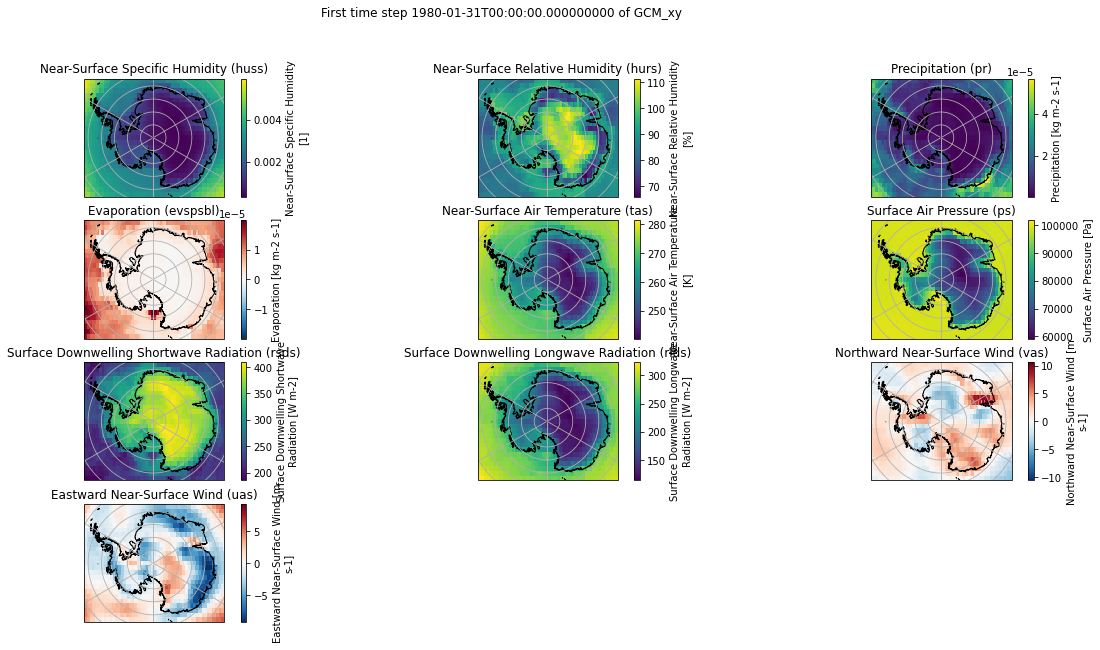

In [5]:
# open from google cloud
# open from google cloud

fileGC = 'ACCESS1-3-stereographic_monthly.nc'

# download from GC:
print(f'Downloading {fileGC} from GC...')
pathGC = f'Chris_data/RawData/MAR-ACCESS1.3/monthly/GCM/'
downloadFileFromGC(pathGC, '', fileGC)

GCM_xy = xr.open_dataset(fileGC)
os.remove(fileGC)
#GCM_xy_plot = GCM_xy.drop(['lat_bnds', 'lon_bnds', 'time_bnds','spatial_ref'])
GCM_xy_plot = GCM_xy.drop(['spatial_ref'])
plotAllVar(GCM_xy_plot, m=4, n=3, name='GCM_xy')

### RCM xy:
#### Vars RCM: 

PLEVLS: [200., 500., 600., 700., 800., 850., 925.]

ATMLAY: [0.99892 , 0.999325, 0.99973]

Atmosphere: 
- CC: Cloud Cover
- **QQP**: Specific Humidity [g/kg] (for 7 PLEV)
- **RH**: Relative Humidity [%] (ATMLAY: 3)

Water mass processes: 
- ME: Meltwater production [mmWE/day] (SECTOR1_1: 1)
- **RF**: Rainfall [mmWE/day] -> [mm/day]
- RU: Run-off of meltwater and rain water [mmWE/day] (SECTOR: 1)
- **SF**: Snowfall [mmWE/day]
- **SMB**: Surface Mass Balance (SMB~SF+RF-RU-SU-SW) [mmWE/day] (SECTOR: 1)
- **SU**: Sublimation and evaporation [mmWE/day] (SECTOR: 1)

Temperature: 
- **TT**: Temperature [°C] (ATMLAY:1, 0.9997)
- **TTP**: Temperature [°C] (PLEV: 7)

Pressure: 
- **SP**: Surface Pressure [hPa]

Radiation: 
- **SWD**: Short Wave Downward [W/m2]
- **LWD**: Long  Wave Downward [W/m2]

Wind speeds:
- **UUP**: x-Wind Speed component [m/s] (PLEV: 7)
- **VVP**: y-Wind Speed component [m/s] (PLEV: 7)

#### One time step:

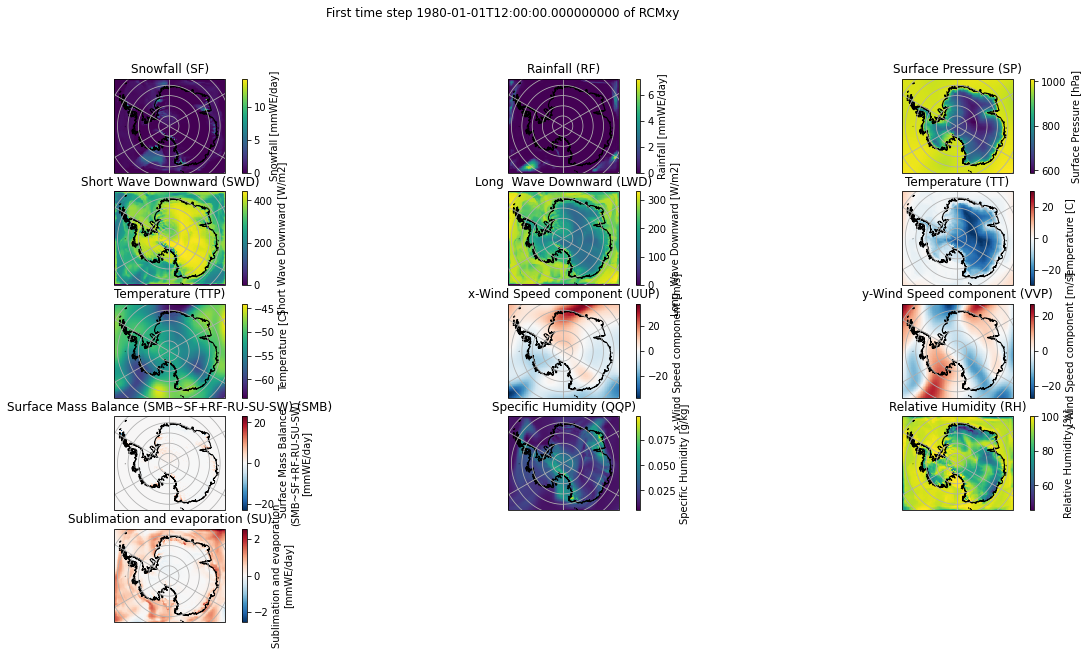

In [6]:
# Select variables that are also in GCM: 

# Rainfall: 
VAR = 'RF'
pathGC, fileGC = pathToFiles(VAR, date1='19800101', date2='19801231')
downloadFileFromGC(pathGC, '', fileGC)
rf = ProcessRCMVar(VAR, xr.open_dataset(fileGC))
os.remove(fileGC)

# Snowfall: 
VAR = 'SF'
pathGC, fileGC = pathToFiles(VAR, date1='19800101', date2='19801231')
downloadFileFromGC(pathGC, '', fileGC)
sf = ProcessRCMVar(VAR, xr.open_dataset(fileGC))
os.remove(fileGC)

# sea level pressure: 
VAR = 'SP'
pathGC, fileGC = pathToFiles(VAR, date1='19800101', date2='19801231')
downloadFileFromGC(pathGC, '', fileGC)
sp = ProcessRCMVar(VAR, xr.open_dataset(fileGC))
os.remove(fileGC)

# radiations:
VAR = 'SWD'
pathGC, fileGC = pathToFiles(VAR, date1='19800101', date2='19801231')
downloadFileFromGC(pathGC, '', fileGC)
swd = ProcessRCMVar(VAR, xr.open_dataset(fileGC))
os.remove(fileGC)

VAR = 'LWD'
pathGC, fileGC = pathToFiles(VAR, date1='19800101', date2='19801231')
downloadFileFromGC(pathGC, '', fileGC)
lwd = ProcessRCMVar(VAR, xr.open_dataset(fileGC))
os.remove(fileGC)

# near surface air temp:
VAR = 'TT'
pathGC, fileGC = pathToFiles(VAR, date1='19800101', date2='19801231')
downloadFileFromGC(pathGC, '', fileGC)
tt = ProcessRCMVar(VAR, xr.open_dataset(fileGC))
os.remove(fileGC)

# wind at surface level (PLEV:0)
VAR = 'UUP'
pathGC, fileGC = pathToFiles(VAR, date1='19800101', date2='19801231')
downloadFileFromGC(pathGC, '', fileGC)
uup = ProcessRCMVar(VAR, xr.open_dataset(fileGC)).isel(PLEV=0)
os.remove(fileGC)

VAR = 'VVP'
pathGC, fileGC = pathToFiles(VAR, date1='19800101', date2='19801231')
downloadFileFromGC(pathGC, '', fileGC)
vvp = ProcessRCMVar(VAR, xr.open_dataset(fileGC)).isel(PLEV=0)
os.remove(fileGC)

# SMB: 
VAR = 'SMB'
pathGC, fileGC = pathToFiles(VAR, date1='19800101', date2='19801231')
downloadFileFromGC(pathGC, '', fileGC)
smb = ProcessRCMVar(VAR, xr.open_dataset(fileGC))
os.remove(fileGC)

# QQP: 
VAR = 'QQP'
pathGC, fileGC = pathToFiles(VAR, date1='19800101', date2='19801231')
downloadFileFromGC(pathGC, '', fileGC)
qqp = ProcessRCMVar(VAR, xr.open_dataset(fileGC)).isel(PLEV=0)
os.remove(fileGC)

# RH: 
VAR = 'RH'
pathGC, fileGC = pathToFiles(VAR, date1='19800101', date2='19801231')
downloadFileFromGC(pathGC, '', fileGC)
rh = ProcessRCMVar(VAR, xr.open_dataset(fileGC))
os.remove(fileGC)

# TTP: 
VAR = 'TTP'
pathGC, fileGC = pathToFiles(VAR, date1='19800101', date2='19801231')
downloadFileFromGC(pathGC, '', fileGC)
ttp = ProcessRCMVar(VAR, xr.open_dataset(fileGC)).isel(PLEV=0)
os.remove(fileGC)

# SU: 
VAR = 'SU'
pathGC, fileGC = pathToFiles(VAR, date1='19800101', date2='19801231')
downloadFileFromGC(pathGC, '', fileGC)
su = ProcessRCMVar(VAR, xr.open_dataset(fileGC))
os.remove(fileGC)


# Put together all variables:
RCMxy = xr.merge([sf, rf, sp, swd, lwd, tt, ttp, uup, vvp, smb, qqp, rh, su])

# Add precipitation as sum of RF and SF:
"""
RCMxy['PR'] = xr.Variable(dims = RCMxy['SF'].dims, 
                            data = RCMxy['SF']+ RCMxy['RF'], 
                            attrs = GCM_xy.pr.attrs)"""

# Basic pre-processing
RCMxy = BasicPreprocRCM(RCMxy.drop('PLEV_bnds'))

plotAllVar(RCMxy, m=5, n=3, name='RCMxy')

## Preprocessing: 

### RCM 
#### Resample to monthly freq and save:

In [7]:
#vars_ = ['SF','RF', 'SP', 'LWD', 'SWD', 'TT', 'UUP', 'VVP', 'SMB']
vars_ = ['RH', 'SU'] 
download = False
if download:
    ! rm -r ../../../data/tmp/*
    for VAR in vars_:
        print(f'{VAR}:\n--------------')
        pathGC = f'Chris_data/RawData/MAR-ACCESS1.3/{VAR}/'
        pathLocal = '../../../data/tmp/'
        filesGC = listFilesGC(pathGC, VAR)

        #------ Download files from GC
        print('Downloading files from GC')
        downloadFilesFromGC(pathGC, pathLocal, filesGC)

        onlyfiles = filesInDirWithVar(pathLocal, VAR)
        print('Examples of files: \n {}'.format(onlyfiles[0]))

        #------ concatenate all years of a variable
        # first year
        if len(onlyfiles) == 121:
            print('Concatenating...')
            f0 = onlyfiles[0]
            df0 = xr.open_dataset(pathLocal+f0)
            # preprocessing and resampling
            df0 = resampleMonthlyMean(BasicPreprocRCM(ProcessRCMVar(VAR, df0)))

            for f in onlyfiles[1:]:
                df = xr.open_dataset(pathLocal+f)
                # preprocessing and resampling
                df = resampleMonthlyMean(BasicPreprocRCM(ProcessRCMVar(VAR, df)))

                # concatenate with previous years
                df0 = xr.concat([df0,df], dim = 'time')

            # save file locally:
            path = '../../data/toGC/'
            name = f'{VAR}_ant-35km_ACCESS1.3_rcp8.5_r1i1p1_ULg-MAR311_v1_monthly.nc'
            df0.to_netcdf(name)

            # upload to GC:
            print('Uploading to GC...')
            print(name)
            pathGC = f'Chris_data/RawData/MAR-ACCESS1.3/monthly/'
            uploadFileToGC(pathGC, name)

            # delete file and temporary directory:
            os.remove(name)
            ! rm ../../../data/tmp/*

        else:
            print(f'Error: len only files is:{len(onlyfiles)}')
            break
            
    # test:
    #f = plt.figure(figsize=(10, 10))
    #map_proj = ccrs.SouthPolarStereo(central_longitude=0.0, globe=None)
    #ax = plt.subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())
    #df0.isel(time = 1)[vars_[0]].plot(ax=ax, x='x', y='y',transform=ccrs.SouthPolarStereo())
    #ax.coastlines('10m', color='black')
    #ax.gridlines()

#### Concatenate all variables:

In [8]:
vars_ = ['SF','RF', 'SP', 'LWD', 'SWD', 'TT', 'UUP', 'VVP', 'SMB', 'TTP', 'QQP', 'RH']
pathGC = f'Chris_data/RawData/MAR-ACCESS1.3/monthly/'
pathLocal = '../../../data/tmp/'

download = False
if download:
    # names of files on GC
    
    vars_wo_wind = ['SF','RF', 'SP', 'LWD', 'SWD', 'TT', 'SMB', 'RH']
    filesGC = [f'{VAR}_ant-35km_ACCESS1.3_rcp8.5_r1i1p1_ULg-MAR311_v1_monthly.nc' for VAR in vars_wo_wind]
    
    # Need to load winds that have been processed to last non nan values per plvls
    vars_w_wind = ['VVP', 'UUP']
    filesGCWind = [f'{VAR}_ant-35km_ACCESS1.3_rcp8.5_r1i1p1_ULg-MAR311_v1_monthly_spwinds.nc' for VAR in vars_w_wind]
    
    # Other vars with plevls: 
    vars_w_plevs = ['TTP', 'QQP']
    filesGCPLEV = [f'{VAR}_ant-35km_ACCESS1.3_rcp8.5_r1i1p1_ULg-MAR311_v1_monthly_spvars.nc' for VAR in vars_w_plevs]
    
    filesGC = filesGC+filesGCWind+filesGCPLEV
    
    # download files and store locally
    downloadFilesFromGC(pathGC, pathLocal, filesGC)

    # concatenate and save nc file to GC
    f0 = filesGC[0]
    df0 = xr.open_dataset(pathLocal+f0)

    for f1 in filesGC[1:]:
        print(f1)
        df1 = xr.open_dataset(pathLocal+f1)
        
        """
        if 'SMB' in f1:
            dim = ('time', 'y', 'x')
            df1['SMB'] = xr.Variable(dims = dim, 
                                        data = df1.SMB.mean(dim='SECTOR'), 
                                        attrs = df1.SMB.attrs)
            df1 = df1.drop_dims(['SECTOR'])"""
        # somehow weird time axis for this variable, one duplicate year
        if 'TTP' in f1:
            df1['time'] = df0.time
            
        df0 = xr.merge([df0,df1])

    # save file locally:
    name = f'MAR(ACCESS1-3)_monthly.nc'
    df0.to_netcdf(name)

    # upload to GC:
    print('Uploading to GC...')
    pathGC = f'Chris_data/RawData/MAR-ACCESS1.3/monthly/RCM/'
    uploadFileToGC(pathGC, name)

    # delete file and temporary directory:
    os.remove(name)
    ! rm ../../../data/tmp/*

    # test:
    plotAllVar(df0, m=5, n=3, name='RCM_xy')

#### Download file:

In [9]:
name = f'MAR(ACCESS1-3)_monthly.nc'
# upload to GC:
print(f'Downloading {name} from GC...')
pathGC = f'Chris_data/RawData/MAR-ACCESS1.3/monthly/RCM/'
downloadFileFromGC(pathGC, '', name)

RCM_xy = xr.open_dataset(name)
RCM_xy

<xarray.Dataset>
Dimensions:      (time: 1452, y: 148, x: 176, PLEV: 7)
Coordinates:
  * time         (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2100-12-31
  * x            (x) float32 -3.01e+06 -2.975e+06 ... 3.08e+06 3.115e+06
  * y            (y) float32 -2.555e+06 -2.52e+06 ... 2.555e+06 2.59e+06
    spatial_ref  int64 ...
  * PLEV         (PLEV) float32 200.0 500.0 600.0 700.0 800.0 850.0 925.0
Data variables:
    SF           (time, y, x) float32 ...
    RF           (time, y, x) float32 ...
    SP           (time, y, x) float32 ...
    LWD          (time, y, x) float32 ...
    SWD          (time, y, x) float32 ...
    TT           (time, y, x) float32 ...
    SMB          (time, y, x) float32 ...
    RH           (time, y, x) float32 ...
    VVP          (time, y, x) float64 ...
    UUP          (time, y, x) float64 ...
    TTP          (time, y, x) float64 ...
    QQP          (time, y, x) float64 ...
Attributes: (12/21)
    CDI:                            Climate Data Interface version 1.9.7.1 (h...
    Conventions:                    CF-1.6
    history:                        Mon Mar  7 10:44:39 2022: ncap2 -O -s SF=...
    institute:                      University of Liege (Belgium)
    contact:                        ckittel@uliege.be
    NCO:                            netCDF Operators version 4.8.1 (Homepage ...
    ...                             ...
    frequency:                      day
    institute_id:                   ULg
    institution:                    University of Liege - Belgium
    model_id:                       ULg-MAR311
    product:                        output
    reference:                      http://www.climato.be

#### Save only SMB:

In [10]:
 # save file locally:
name = f'MAR(ACCESS1-3)_monthly_SMB.nc'
smb = RCM_xy.SMB
smb.to_netcdf(name)
smb

<xarray.DataArray 'SMB' (time: 1452, y: 148, x: 176)>
[37821696 values with dtype=float32]
Coordinates:
  * time         (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2100-12-31
  * x            (x) float32 -3.01e+06 -2.975e+06 ... 3.08e+06 3.115e+06
  * y            (y) float32 -2.555e+06 -2.52e+06 ... 2.555e+06 2.59e+06
    spatial_ref  int64 0
Attributes:
    history:    From ICE.p79.1980.01.01-10
    long_name:  Surface Mass Balance (SMB~SF+RF-RU-SU-SW)
    units:      mmWE/day

In [11]:
# upload to GC:
print('Uploading to GC...')
pathGC = f'Chris_data/RawData/MAR-ACCESS1.3/monthly/RCM/'
uploadFileToGC(pathGC, name)

Uploading to GC...


### GCM:
So that is similar to RCM

In [13]:
def MovingAverageFilter(df, size = 3):
    Smoothed = xr.Dataset(coords = df.coords, attrs = df.attrs)
    vars_ = list(df.data_vars)
    for var in vars_:
        smoothed = ndimage.uniform_filter(df[var].values, size=size, mode='nearest')
        Smoothed[var] = xr.Variable(dims = df[var].dims, 
                                data = smoothed, 
                                attrs = df[var].attrs)
        
    return Smoothed

In [14]:
# open from google cloud
fileGC = 'ACCESS1-3-stereographic_monthly.nc'

# upload to GC:
print(f'Downloading {fileGC} from GC...')
pathGC = f'Chris_data/RawData/MAR-ACCESS1.3/monthly/GCM/'
downloadFileFromGC(pathGC, '', fileGC)

GCM_xy = xr.open_dataset(fileGC)
os.remove(fileGC)

# remove evaporation, not interesting:
GCM_xy = GCM_xy.drop('evspsbl')

GCM_xy = GCM_xy.rio.write_crs("epsg:3031")
GCM_xy.attrs['crs'] = 3031

# Slice to same time as RCM:
#Firstdate = datetime(1980,1,31, 12, 0,0)
#Enddate = datetime(2100,12,31, 12, 0,0)

#GCM_xy = GCM_xy.sel(time = slice(Firstdate, Enddate))
#GCM_xy = GCM_xy.drop(['lat_bnds', 'lon_bnds', 'time_bnds'])

# change prec to right units (mmWE/day): 
var = 'pr'
GCM_xy[var] = xr.Variable(dims = GCM_xy[var].dims, 
                            data = GCM_xy[var]*86400, 
                            attrs = GCM_xy.pr.attrs)
GCM_xy[var].attrs["units"] = "mmWE/day"

# change pressure from pa to hpa: 1pa = 0.01 hPa 
var = 'ps'
GCM_xy[var] = xr.Variable(dims = GCM_xy[var].dims, 
                            data = GCM_xy[var]*0.01, 
                            attrs = GCM_xy.ps.attrs)
GCM_xy[var].attrs["units"] = "hpa"

# change temperature from K to C: 1K = -272,15 °C 
var = 'tas'
GCM_xy[var] = xr.Variable(dims = GCM_xy[var].dims, 
                            data = GCM_xy[var]-272.15, 
                            attrs = GCM_xy.tas.attrs)
GCM_xy[var].attrs["units"] = "C"

# change specific humidity from g/g to g/Kg 
var = 'huss'
GCM_xy[var] = xr.Variable(dims = GCM_xy[var].dims, 
                            data = GCM_xy[var]*1000, 
                            attrs = GCM_xy.huss.attrs)
GCM_xy[var].attrs["units"] = "g/Kg"

# resample so that months start on same date as RCM
GCM_xy = resampleMonthlyMean(GCM_xy)

# apply smoothing average:
# Smooth with moving average:
GCM_xy = MovingAverageFilter(GCM_xy)
GCM_xy
GCM_xy

<xarray.Dataset>
Dimensions:      (time: 1452, x: 90, y: 25)
Coordinates:
    spatial_ref  int64 0
  * time         (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2100-12-31
  * x            (x) float32 -2.992e+06 -2.924e+06 ... 2.992e+06 3.06e+06
  * y            (y) float32 -2.472e+06 -2.266e+06 ... 2.266e+06 2.472e+06
Data variables:
    huss         (time, y, x) float32 5.202 5.111 5.023 ... 4.286 4.36 4.404
    hurs         (time, y, x) float32 84.41 84.51 84.65 ... 84.99 84.95 84.87
    pr           (time, y, x) float64 3.288 3.287 3.272 ... 2.766 2.801 2.777
    tas          (time, y, x) float32 7.595 7.313 7.031 ... 4.509 4.766 4.926
    ps           (time, y, x) float32 1.005e+03 1.005e+03 ... 986.6 987.0
    rsds         (time, y, x) float32 183.7 181.3 178.7 ... 232.8 233.5 235.1
    rlds         (time, y, x) float32 322.9 322.1 321.5 ... 298.8 299.7 300.0
    vas          (time, y, x) float32 0.06454 0.1697 0.2446 ... -0.9415 -1.013
    uas          (time, y, x) float32 2.797 2.612 2.391 ... 5.294 5.598 5.787
Attributes: (12/29)
    institution:            CSIRO (Commonwealth Scientific and Industrial Res...
    institute_id:           CSIRO-BOM
    experiment_id:          historical
    source:                 ACCESS1-3 2011. Atmosphere: AGCM v1.0 (N96 grid-p...
    model_id:               ACCESS1.3
    forcing:                GHG, Oz, SA, Sl, Vl, BC, OC, (GHG = CO2, N2O, CH4...
    ...                     ...
    title:                  ACCESS1-3 model output prepared for CMIP5 historical
    parent_experiment:      pre-industrial control
    modeling_realm:         atmos
    realization:            1
    cmor_version:           2.8.0
    crs:                    3031

In [15]:
# Save file
name = 'ACCESS1-3-stereographic_monthly_cleaned.nc'

# save file locally:
GCM_xy.attrs['crs'] = 3031
GCM_xy.to_netcdf(name)

# upload to GC:
print(f'Uploading {name} to GC...')
pathGC = f'Chris_data/RawData/MAR-ACCESS1.3/monthly/GCM/'
uploadFileToGC(pathGC, name)
os.remove(name)

Uploading ACCESS1-3-stereographic_monthly_cleaned.nc to GC...


#### Compare GCM-RCM variables:

In [16]:
def plotAllVar2Xr(
    GCM_xy,  # xr.Dataset
    GCM_xy2,
    m: int = 7,  # number of rows in plot
    n: int = 2,  # number of columns in plot
    name: str = "GCM",  # name of dataset plotted, for title
    time: int = 0,
    vars_ = None
):  # time step that should be plotted
    if vars_ == None:
        vars_ = sorted(list(GCM_xy.data_vars))
    coords = list(GCM_xy.coords)
    f = plt.figure(figsize=(15, 20))
    map_proj = ccrs.SouthPolarStereo(central_longitude=0.0, globe=None)
    
    k = 1
    for i in range(len(vars_)):
        var = vars_[i]
        ax = plt.subplot(m, n, k, projection=ccrs.SouthPolarStereo())
        max = np.max([np.nanmax(GCM_xy[var].isel(time=time).values), np.nanmax(GCM_xy2[var].isel(time=time).values)])
        min = np.min([np.nanmin(GCM_xy[var].isel(time=time).values), np.nanmin(GCM_xy2[var].isel(time=time).values)])
        
        GCM_xy[var].isel(time=time).plot(
            ax=ax, x="x", y="y", vmin = min, vmax = max, transform=ccrs.SouthPolarStereo(), add_colorbar=True
        )
        ax.coastlines("10m", color="black")
        ax.gridlines()
        ax.set_title(f"{GCM_xy[var].long_name} RCM ({var})")
        k+=1
        ax = plt.subplot(m, n, k, projection=ccrs.SouthPolarStereo())
        GCM_xy2[var].isel(time=time).plot(
            ax=ax, x="x", y="y", vmin = min, vmax = max, transform=ccrs.SouthPolarStereo(), add_colorbar=True
        )
        ax.coastlines("10m", color="black")
        ax.gridlines()
        ax.set_title(f"{GCM_xy2[var].long_name} GCM ({var})")
        k+=1

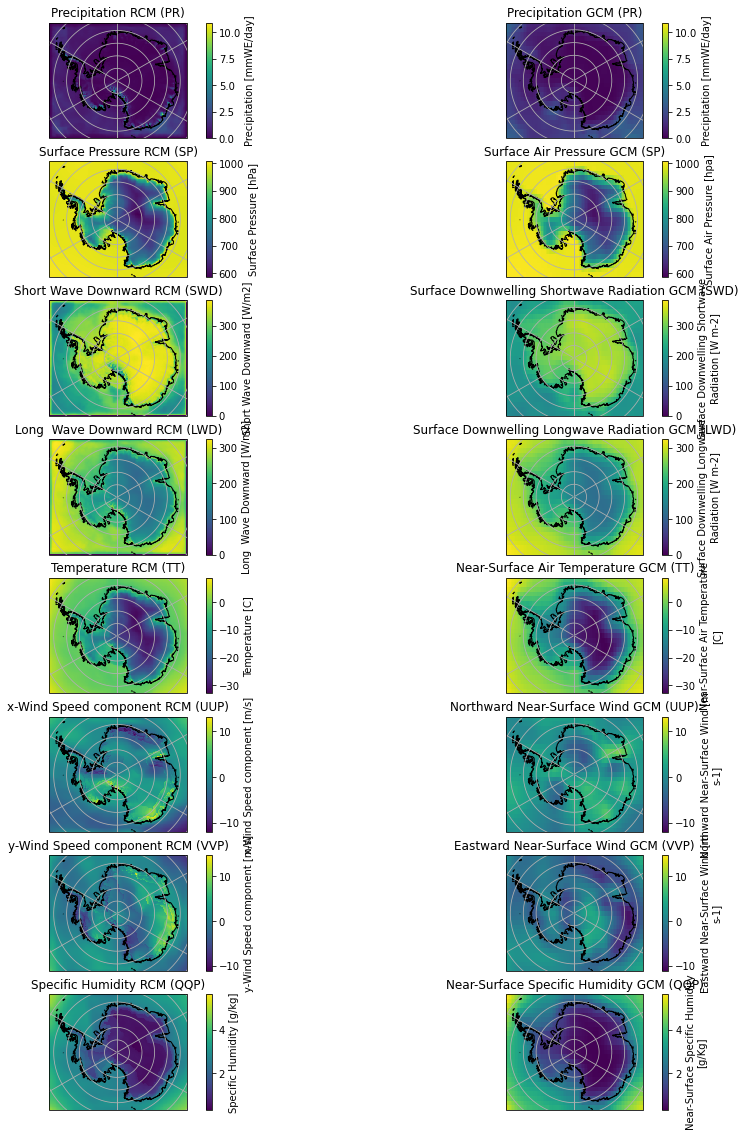

In [17]:
name = 'ACCESS1-3-stereographic_monthly_cleaned.nc'
# upload to GC:
print(f'Downloading {name} from GC...')
pathGC = f'Chris_data/RawData/MAR-ACCESS1.3/monthly/GCM/'
downloadFileFromGC(pathGC, '', name)

GCM_xy = xr.open_dataset(name)
GCM_xy = GCM_xy.rename_vars({'ps':'SP', 'uas':'VVP', 'vas':'UUP', 'pr':'PR', 
                       'tas': 'TT', 
                       'rsds':'SWD', 'rlds':'LWD', 'huss':'QQP', 'hurs':'RH'})

# Add precipitation variable:
RCM_xy['PR'] = xr.Variable(dims = RCM_xy['RF'].dims, 
                            data = RCM_xy['RF']+RCM_xy['SF'], 
                            attrs = GCM_xy.PR.attrs) 

vars =['PR', 'SP', 'SWD', 'LWD','TT', 'UUP', 'VVP', 'QQP']
plotAllVar2Xr(
    RCM_xy.drop(['SMB']),  # xr.Dataset
    GCM_xy,
    m = 8,
    n = 2,
    vars_ = vars
)

## GCM like RCM
Reproject RCM xy on GCM xy grid: Creates fake GCM like outputs from RCM

In [18]:
# GCMxy: 
name = 'ACCESS1-3-stereographic_monthly_cleaned.nc'
# upload to GC:
print(f'Downloading {name} from GC...')
pathGC = f'Chris_data/RawData/MAR-ACCESS1.3/monthly/GCM/'
downloadFileFromGC(pathGC, '', name)

GCM_xy = xr.open_dataset(name)

In [19]:
# RCM xy:
# open from google cloud
fileGC = f'MAR(ACCESS1-3)_monthly.nc'
# upload to GC:
print(f'Downloading {fileGC} from GC...')
pathGC = f'Chris_data/RawData/MAR-ACCESS1.3/monthly/RCM/'
downloadFileFromGC(pathGC, '', fileGC)

RCM_xy = xr.open_dataset(fileGC)
os.remove(fileGC)
RCM_xy

<xarray.Dataset>
Dimensions:      (time: 1452, y: 148, x: 176, PLEV: 7)
Coordinates:
  * time         (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2100-12-31
  * x            (x) float32 -3.01e+06 -2.975e+06 ... 3.08e+06 3.115e+06
  * y            (y) float32 -2.555e+06 -2.52e+06 ... 2.555e+06 2.59e+06
    spatial_ref  int64 ...
  * PLEV         (PLEV) float32 200.0 500.0 600.0 700.0 800.0 850.0 925.0
Data variables:
    SF           (time, y, x) float32 ...
    RF           (time, y, x) float32 ...
    SP           (time, y, x) float32 ...
    LWD          (time, y, x) float32 ...
    SWD          (time, y, x) float32 ...
    TT           (time, y, x) float32 ...
    SMB          (time, y, x) float32 ...
    RH           (time, y, x) float32 ...
    VVP          (time, y, x) float64 ...
    UUP          (time, y, x) float64 ...
    TTP          (time, y, x) float64 ...
    QQP          (time, y, x) float64 ...
Attributes: (12/21)
    CDI:                            Climate Data Interface version 1.9.7.1 (h...
    Conventions:                    CF-1.6
    history:                        Mon Mar  7 10:44:39 2022: ncap2 -O -s SF=...
    institute:                      University of Liege (Belgium)
    contact:                        ckittel@uliege.be
    NCO:                            netCDF Operators version 4.8.1 (Homepage ...
    ...                             ...
    frequency:                      day
    institute_id:                   ULg
    institution:                    University of Liege - Belgium
    model_id:                       ULg-MAR311
    product:                        output
    reference:                      http://www.climato.be

In [20]:
# Compare resolutions
print("GCM with crs x/y:\n----------------\n")
print_raster(GCM_xy.tas)
print("RCM with crs x/y:\n----------------\n")
print_raster(RCM_xy.TTP)

GCM with crs x/y:
----------------

shape: (25, 90)
resolution: (68000.0, 206000.0)
bounds: (-3026000.0, 2575000.0, 3094000.0, -2575000.0)
CRS: EPSG:3031

RCM with crs x/y:
----------------

shape: (148, 176)
resolution: (35000.0, 35000.0)
bounds: (-3027500.0, 2607500.0, 3132500.0, -2572500.0)
CRS: EPSG:3031



In [21]:
# Reproject
vars_ = list(RCM_xy.keys())
GCM_like = xr.Dataset()
dim = ('time', 'y', 'x')
for var in vars_:
    GCM_like[var] = xr.Variable(dims = dim, 
                                data = RCM_xy[var].rio.reproject_match(GCM_xy.tas), 
                                attrs = RCM_xy[var].attrs)
GCM_like = GCM_like.assign_coords(RCM_xy[var].rio.reproject_match(GCM_xy.tas).coords)

# drop RH:
GCM_like = GCM_like.drop('RH')

# add precipitation:
GCM_like['PR'] = xr.Variable(dims = GCM_like['RF'].dims, 
                            data = GCM_like['RF']+GCM_like['SF'], 
                            attrs = GCM_xy.pr.attrs) 

### Transform winds
Get corresponding longitude for each point (i,j) in (x,y) coordinates:

In [22]:
# Create a pyproj.Transformer to transform each point 
# in xmesh and ymesh into a location in the polar coordinates 
target_crs = pyproj.CRS(3031) # Global lat-lon coordinate system
source_crs = pyproj.CRS(4326) # Coordinate system of the file
    
polar_to_latlon = pyproj.Transformer.from_crs(target_crs,source_crs, always_xy = True)

gridx, gridy = GCM_like.x, GCM_like.y
xmesh, ymesh = np.meshgrid(gridx, gridy)

lon_om2, lat_om2 = polar_to_latlon.transform(xmesh, ymesh)

# Create xarray.DataArray for the coordinates with matching dimensions.
lon_om2 = xr.DataArray(lon_om2, dims=('y','x'))
lat_om2 = xr.DataArray(lat_om2, dims=('y','x'))

In [23]:
import math
transformWinds = True

if transformWinds:
    dr = math.pi / 180

    GEddxx = 90
    deltaphi = 90 - GEddxx

    # longitude (in the MAR code, the lon is expressed in hours, so you can directly use the longitude in ° here)
    # lon_deg = lon_om2*15
    lon_deg = lon_om2

    time = 0

    ts, ys, xs = GCM_like.UUP.shape
    windNorth, windEast = np.empty((ts, ys, xs)), np.empty((ts, ys, xs))
    windx = GCM_like.UUP
    windy = GCM_like.VVP
    for i in tqdm(range(GCM_like.dims["y"])):
        for j in range(GCM_like.dims["x"]):
            phi = (-1.0) * (lon_deg.isel(y=i, x=j).values + deltaphi) * dr
            cphi = math.cos(-phi)
            sphi = math.sin(-phi)

            windEast[:, i, j] = cphi * windx[:,i, j] - sphi * windy[:,i, j]
            windNorth[:, i, j] = sphi * windx[:,i, j] + cphi * windy[:,i, j]

    coords = {
        "time": GCM_like.coords["time"],
        "y": GCM_like.coords["y"],
        "x": GCM_like.coords["x"],
    }
    #windsXr = xr.Dataset(coords=coords, attrs=GCM_like.attrs)
    GCM_like["NW"] = xr.Variable(
        dims=("time", "y", "x"), data=windNorth, attrs=GCM_xy.vas.attrs
    )
    GCM_like["EW"] = xr.Variable(
        dims=("time", "y", "x"), data=windEast, attrs=GCM_xy.uas.attrs
    )

100%|██████████| 25/25 [00:05<00:00,  4.20it/s]


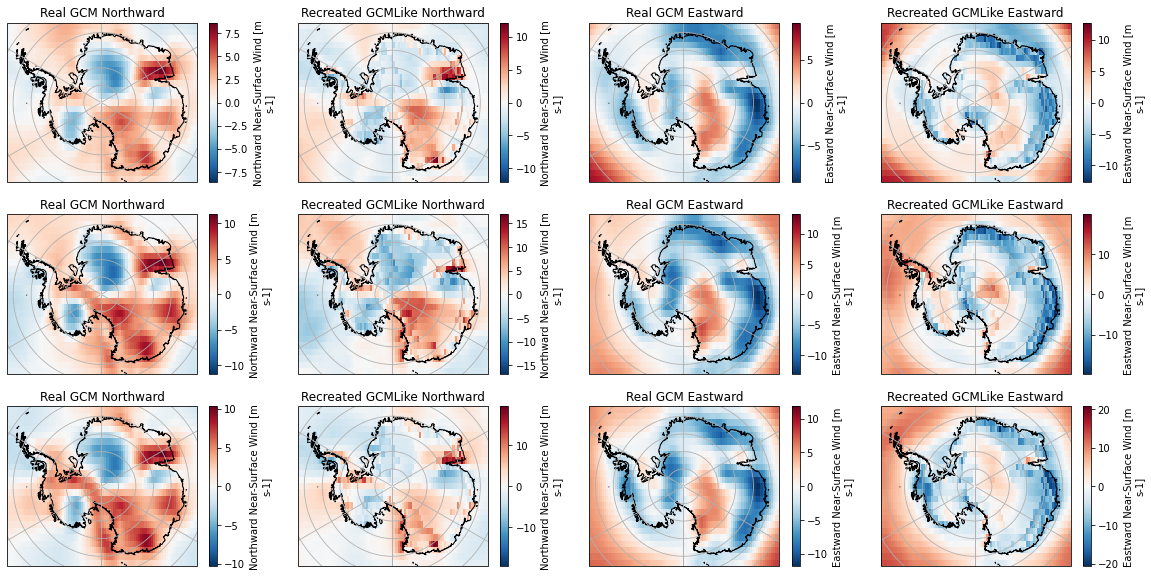

In [24]:
import random as rn
f = plt.figure(figsize=(20, 10))
N = 3
m = 1
for i in range(N):
    time = rn.randint(0, GCM_xy.dims['time'])
    ax = plt.subplot(N, 4, m, projection=ccrs.SouthPolarStereo())
    VAR = 'vas'
    GCM_xy.isel(time=time)[VAR].plot(ax=ax, x='x',
                    transform=ccrs.SouthPolarStereo(), add_colorbar=True)

    ax.coastlines('10m', color='black')
    ax.gridlines()
    ax.set_title('Real GCM Northward')
    m+=1
    ax = plt.subplot(N, 4, m, projection=ccrs.SouthPolarStereo())
    GCM_like.isel(time=time).NW.plot(ax=ax, x='x',
                    transform=ccrs.SouthPolarStereo(), add_colorbar=True)

    ax.coastlines('10m', color='black')
    ax.gridlines()
    ax.set_title('Recreated GCMLike Northward')
    m+=1

    ax = plt.subplot(N, 4,m, projection=ccrs.SouthPolarStereo())
    VAR = 'uas'
    GCM_xy.isel(time=time)[VAR].plot(ax=ax, x='x',
                    transform=ccrs.SouthPolarStereo(), add_colorbar=True)

    ax.coastlines('10m', color='black')
    ax.gridlines()
    ax.set_title('Real GCM Eastward')
    m+=1
    ax = plt.subplot(N, 4, m, projection=ccrs.SouthPolarStereo())
    GCM_like.isel(time=time).EW.plot(ax=ax, x='x',
                    transform=ccrs.SouthPolarStereo(), add_colorbar=True)

    ax.coastlines('10m', color='black')
    ax.gridlines()
    ax.set_title('Recreated GCMLike Eastward')
    m+=1

### Smooth with moving average:

In [25]:
# Smooth with moving average:
GCM_like_smoothed = MovingAverageFilter(GCM_like)
GCM_like_smoothed

<xarray.Dataset>
Dimensions:      (x: 90, y: 25, time: 1452)
Coordinates:
    spatial_ref  int64 0
  * x            (x) float32 -2.992e+06 -2.924e+06 ... 2.992e+06 3.06e+06
  * y            (y) float32 -2.472e+06 -2.266e+06 ... 2.266e+06 2.472e+06
  * time         (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2100-12-31
Data variables: (12/14)
    SF           (time, y, x) float32 4.954e-06 1.27e-05 ... 0.00461 0.0006482
    RF           (time, y, x) float32 0.1348 0.2703 0.4712 ... 0.4493 0.318
    SP           (time, y, x) float32 1.005e+03 1.005e+03 ... 986.7 987.0
    LWD          (time, y, x) float32 267.7 277.8 288.8 ... 281.0 276.8 272.7
    SWD          (time, y, x) float32 279.2 257.5 232.0 ... 270.6 283.2 294.2
    TT           (time, y, x) float32 6.394 6.191 5.858 ... 3.271 3.542 3.711
    ...           ...
    UUP          (time, y, x) float64 -2.807 -2.699 -2.567 ... 4.736 4.805 4.84
    TTP          (time, y, x) float64 1.661 1.556 1.387 ... -0.4152 -0.2779
    QQP          (time, y, x) float64 4.471 4.451 4.413 ... 3.766 3.82 3.849
    PR           (time, y, x) float32 0.1349 0.2703 0.4712 ... 0.4539 0.3186
    NW           (time, y, x) float64 -0.5912 -0.6433 -0.6483 ... -0.95 -0.9829
    EW           (time, y, x) float64 5.186 5.029 4.758 ... 8.532 8.855 9.041

In [26]:
# Drop x-y winds:
GCM_like_smoothed = GCM_like_smoothed.drop(['UUP', 'VVP'])

# Save file
fileGC = 'MAR(ACCESS1-3)-stereographic_monthly_GCM_like.nc'

# save file locally:
GCM_like_smoothed.attrs['crs'] = 3031
GCM_like_smoothed.to_netcdf(fileGC)

# upload to GC:
print(f'Uploading {fileGC} to GC...')
pathGC = f'Chris_data/RawData/MAR-ACCESS1.3/monthly/RCM/'
uploadFileToGC(pathGC, fileGC)
os.remove(fileGC)

Uploading MAR(ACCESS1-3)-stereographic_monthly_GCM_like.nc to GC...


In [27]:
# Read GCM like RCM:
fileGC = 'MAR(ACCESS1-3)-stereographic_monthly_GCM_like.nc'

pathGC = f'Chris_data/RawData/MAR-ACCESS1.3/monthly/RCM/'
downloadFileFromGC(pathGC, '', fileGC)

GCMLike = xr.open_dataset(fileGC)
os.remove(fileGC)
GCMLike

<xarray.Dataset>
Dimensions:      (x: 90, y: 25, time: 1452)
Coordinates:
    spatial_ref  int64 ...
  * x            (x) float32 -2.992e+06 -2.924e+06 ... 2.992e+06 3.06e+06
  * y            (y) float32 -2.472e+06 -2.266e+06 ... 2.266e+06 2.472e+06
  * time         (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2100-12-31
Data variables:
    SF           (time, y, x) float32 ...
    RF           (time, y, x) float32 ...
    SP           (time, y, x) float32 ...
    LWD          (time, y, x) float32 ...
    SWD          (time, y, x) float32 ...
    TT           (time, y, x) float32 ...
    SMB          (time, y, x) float32 ...
    TTP          (time, y, x) float64 ...
    QQP          (time, y, x) float64 ...
    PR           (time, y, x) float32 ...
    NW           (time, y, x) float64 ...
    EW           (time, y, x) float64 ...
Attributes:
    crs:      3031

In [28]:
print("GCM_like with crs x/y:\n----------------\n")
print_raster(GCM_like_smoothed)

GCM_like with crs x/y:
----------------

shape: (25, 90)
resolution: (68000.0, 206000.0)
bounds: (-3026000.0, 2575000.0, 3094000.0, -2575000.0)
CRS: EPSG:3031



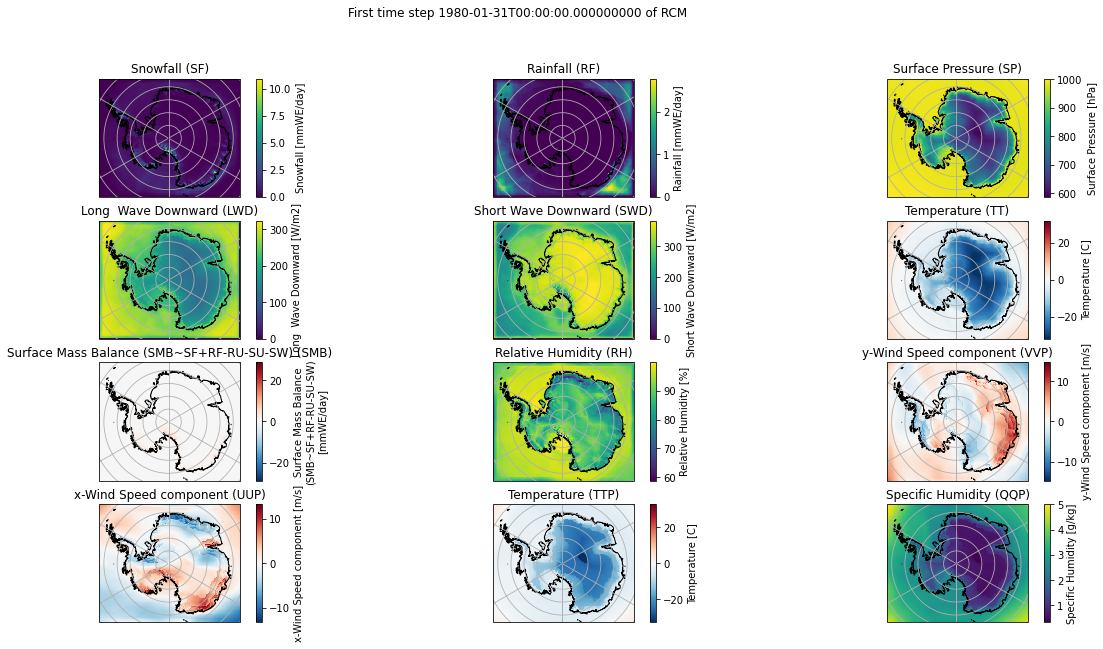

In [29]:
plotAllVar(RCM_xy, m=4, n=3, name='RCM')

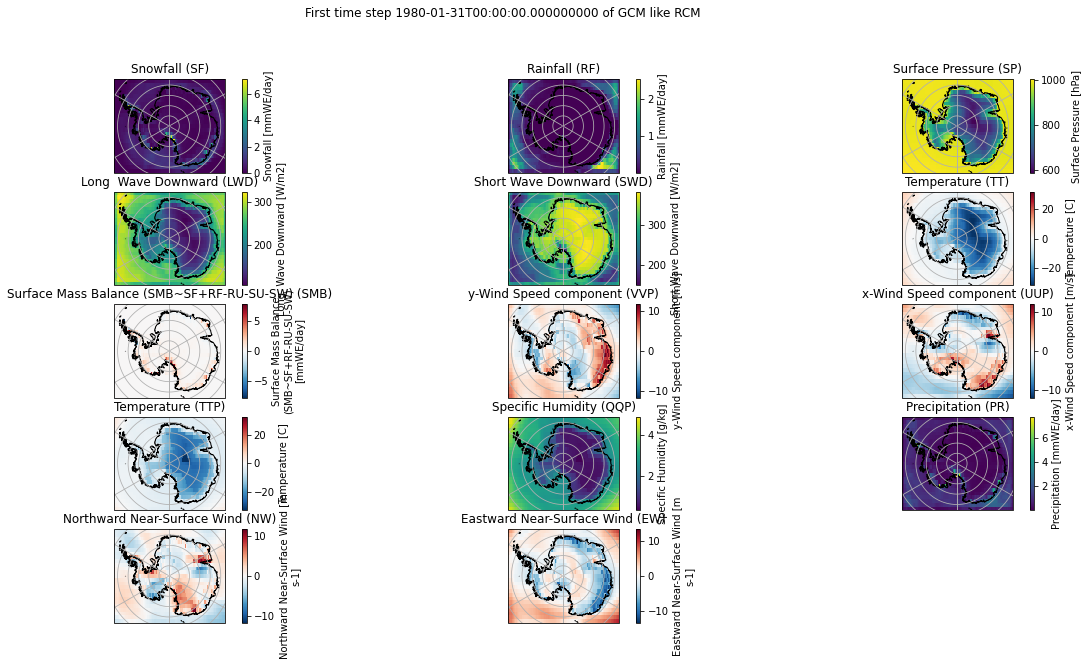

In [30]:
plotAllVar(GCM_like, m=5, n=3, name='GCM like RCM')

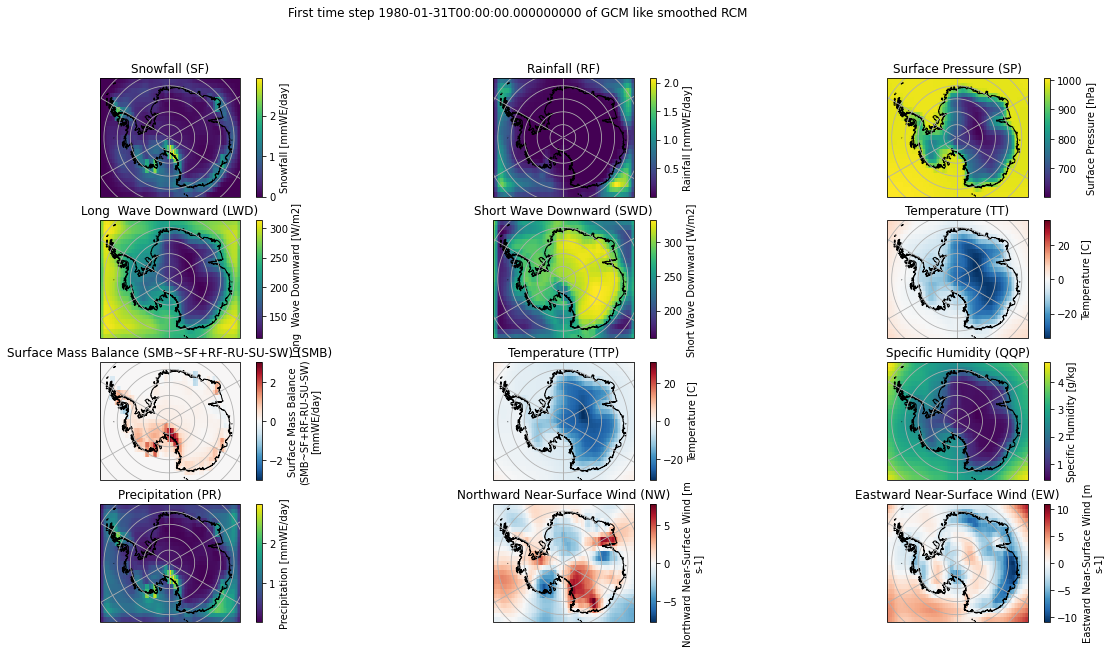

In [31]:
plotAllVar(GCM_like_smoothed, m=4, n=3, name='GCM like smoothed RCM')

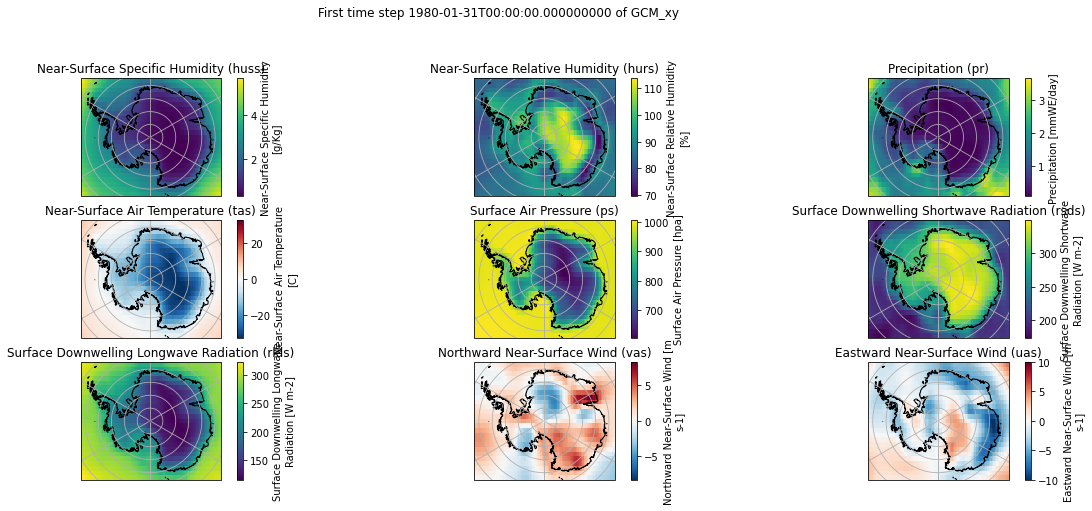

In [32]:
plotAllVar(GCM_xy, m=4, n=3, name='GCM_xy')

## Compare variables between GCM and GCMLike:

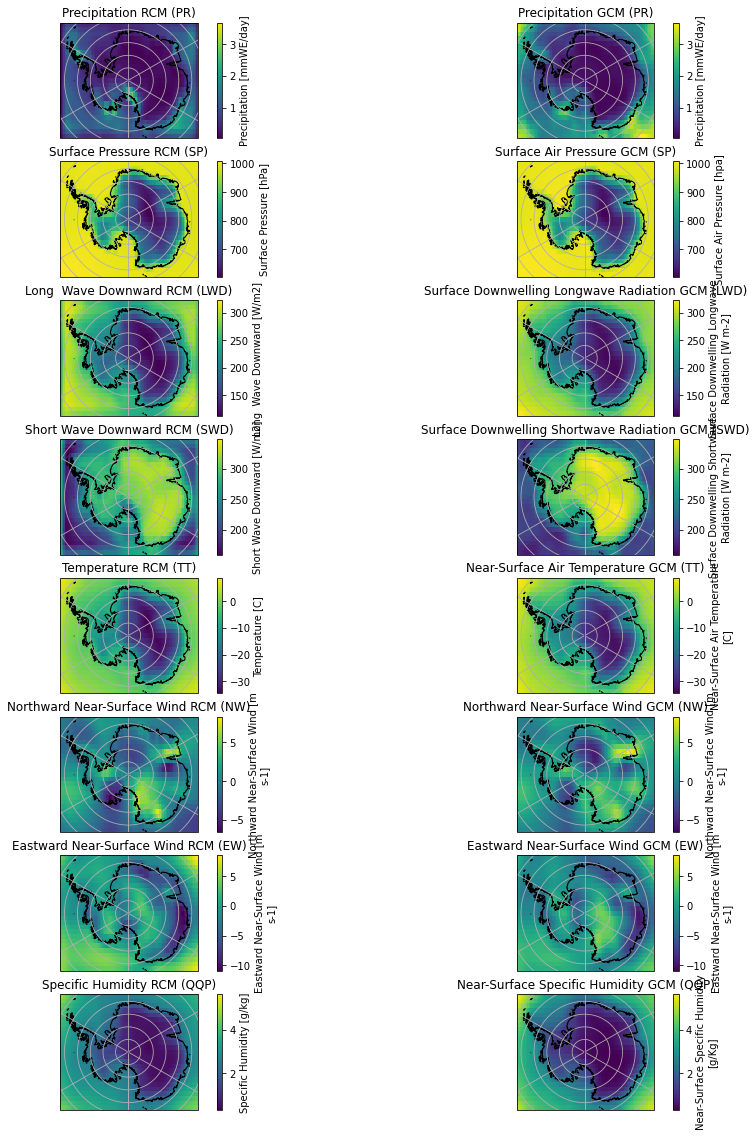

In [33]:
vars =['PR', 'SP', 'LWD','SWD','TT', 'NW', 'EW', 'QQP']
# GCMxy: 
name = 'ACCESS1-3-stereographic_monthly_cleaned.nc'
# upload to GC:
print(f'Downloading {name} from GC...')
pathGC = f'Chris_data/RawData/MAR-ACCESS1.3/monthly/GCM/'
downloadFileFromGC(pathGC, '', name)

GCM_xy = xr.open_dataset(name)
GCM_xy = GCM_xy.rename_vars({'ps':'SP', 'uas':'EW', 'vas':'NW', 'pr':'PR', 
                       'tas': 'TT', 
                       'rsds':'SWD', 'rlds':'LWD', 'huss':'QQP', 'hurs':'RH'})

plotAllVar2Xr(
    GCMLike.drop(['SMB']),  # xr.Dataset
    GCM_xy,
    m = 8,
    n = 2,
    vars_ = vars
)